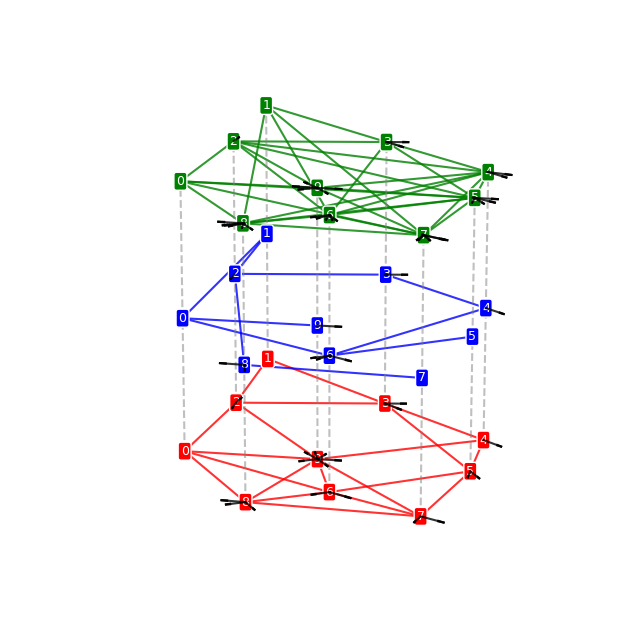

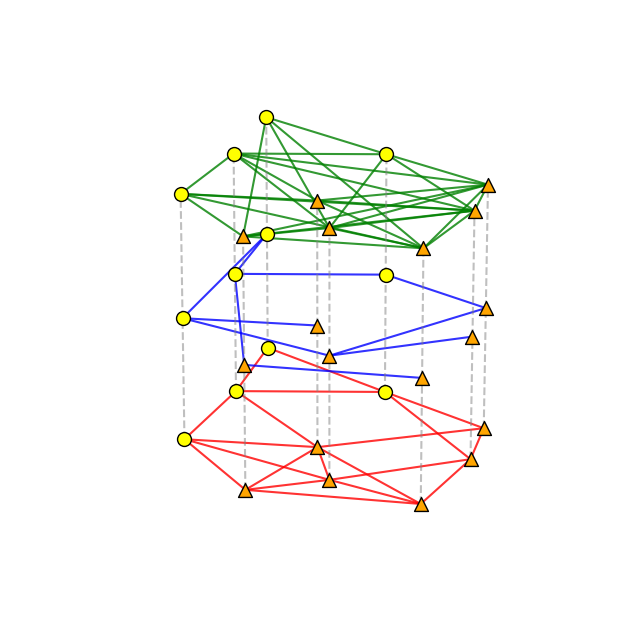

In [63]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def control_point(p1, p2, curvature):
  """Calculates the control point for a quadratic Bezier curve.

  Args:
    p1: The starting point of the curve (numpy array).
    p2: The ending point of the curve (numpy array).
    curvature: A factor controlling the curvature (0 for straight line,
               positive values for curves).

  Returns:
    The control point as a numpy array.
  """
  midpoint = (p1 + p2) / 2
  # Calculate a perpendicular vector
  perp_vector = np.array([p2[1] - p1[1], p1[0] - p2[0]])
  perp_vector = perp_vector / np.linalg.norm(perp_vector)  # Normalize
  control_point = midpoint + curvature * perp_vector
  return control_point

def plot_curve_with_arrow(ax, p0, p1, p2, z_layer, link_color, show_arrow=False, arrow_scale=0.1, arrow_color='black'):
  t_vals = np.linspace(0, 1, 100)  
  curve_x = (1 - t_vals) ** 2 * p0[0] + 2 * (1 - t_vals) * t_vals * p1[0] + t_vals ** 2 * p2[0]
  curve_y = (1 - t_vals) ** 2 * p0[1] + 2 * (1 - t_vals) * t_vals * p1[1] + t_vals ** 2 * p2[1]
  curve_z = np.full_like(curve_x, z_layer)  
  ax.plot(curve_x, curve_y, curve_z, color=link_color, alpha=0.8)

  if show_arrow:  
    # Calculate the tangent vector at the end of the curve for accurate arrow direction
    tangent_x = 2 * (1 - t_vals[-1]) * (p1[0] - p0[0]) + 2 * t_vals[-1] * (p2[0] - p1[0])
    tangent_y = 2 * (1 - t_vals[-1]) * (p1[1] - p0[1]) + 2 * t_vals[-1] * (p2[1] - p1[1])

    direction = np.array([tangent_x, tangent_y, 0]) 
    if np.linalg.norm(direction) == 0:
      return  
    direction = direction / np.linalg.norm(direction) * arrow_scale

    arrow_start = np.array([curve_x[-2], curve_y[-2], curve_z[-2]]) 


    ax.quiver(arrow_start[0], arrow_start[1], arrow_start[2],
              direction[0], direction[1], direction[2],
              color=arrow_color, alpha=0.8, arrow_length_ratio=0.3) 

def inter_layer_links(G, layout, layers_z_axis, ax=None, interlayer_color='gray', alpha=0.5, linestyle='--'):
    """Draws inter-layer links between corresponding nodes in different layers.

    Args:
      G: A list of NetworkX graphs representing the layers.
      layout: A dictionary mapping nodes to their (x, y) coordinates.
      layers_z_axis: A list of z-coordinates for each layer.
      ax: The Matplotlib 3D axes object.
      interlayer_color: The color of the inter-layer links.
      alpha: The transparency of the inter-layer links.
      linestyle: The line style for the inter-layer links (e.g., '--' for dashed).
    """
    num_layers = len(G)
    for node in G[0].nodes(): 
        for i in range(num_layers - 1):
            x1, y1 = layout[node]
            z1 = layers_z_axis[i]
            x2, y2 = layout[node]
            z2 = layers_z_axis[i+1]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color=interlayer_color, alpha=alpha, linestyle=linestyle) 


# Updated plot_graph function to add node labels and arrows
def plot_graph(G, pos, color='blue', size=100,
edgecolor='k', alpha=1, curvature=0.1, z=0, ax=None,
nodes_color=None, nodes_shape=None,
show_labels=False, labels = None, labels_color = 'white',
show_arrows=False,  arrow_scale=0.1, arrow_color = 'black'):

    if nodes_color is None:
        nodes_color = [color] * len(G.nodes())

    if nodes_shape is None:
        nodes_shape = ['o'] * len(G.nodes())

    if labels is None:
        labels = {node: str(node) for node in G.nodes()}  # Default label is the node number

    # Plot nodes

    for i, node in enumerate(G.nodes()):
        x, y = pos[node]
        
        # Optionally show node labels
        if show_labels:
            # Add the label next to the node
            ax.text(x, y, z, labels[node], color=labels_color, fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor=color, edgecolor=labels_color, boxstyle='round,pad=0.2'))
        else:
            ax.scatter(x, y, z, color=nodes_color[i], marker=nodes_shape[i], s=size, edgecolor=edgecolor, alpha=alpha, zorder=2)


    # Plot edges with optional arrows
    for edge in G.edges():
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        p1 = np.array([x1, y1])
        p2 = np.array([x2, y2])
        control = control_point(p1, p2, curvature)  # Compute control point for curvature
        plot_curve_with_arrow(ax, p1, control, p2, z, color, show_arrow=show_arrows,  arrow_scale=arrow_scale, arrow_color = arrow_color)  # Draw curved edge with arrows



# Modify the multiplex plot function to accept show_arrows and show_labels arguments
def plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color=None, nodes_shape=None,
intralayer_links_curvature=0.3, show_arrows=False, show_labels=False, labels = None,
arrow_scale  = 0.1, arrow_color = 'black'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(G)):
        plot_graph(G[i], layout, layers_colors[i], curvature=intralayer_links_curvature, z=layers_z_axis[i],
                   nodes_color=nodes_color, nodes_shape=nodes_shape, ax=ax, show_arrows=show_arrows,
                   show_labels=show_labels, arrow_scale=arrow_scale, arrow_color = arrow_color)

    inter_layer_links(G, layout, layers_z_axis, ax=ax)

    # Remove background, axis, and grid
    ax.set_axis_off()  # Turn off the axes
    ax.grid(False)  # Turn off the grid

    # Set viewing angle and plot
    ax.view_init(elev=20., azim=-60)  # Adjust view angle if needed
    plt.show()

# Example usage
# Parameters: n = number of nodes, k = each node is connected to k nearest neighbors in ring topology, p = rewiring probability
n = 10  # Number of nodes
k1, k2, k3 = 4, 3, 6  # Each node is connected to different neighbors in different layers
p1, p2, p3 = 0.3, 0.6, 0.2  # Rewiring probabilities
# Generate Watts-Strogatz graphs for each layer
G1 = nx.watts_strogatz_graph(n, k1, p1)
G2 = nx.watts_strogatz_graph(n, k2, p2)
G3 = nx.watts_strogatz_graph(n, k3, p3)
G = [G1, G2, G3]
layout = nx.spring_layout(G1, dim=2)
layers_z_axis = [0,3,6]
layers_colors = ['red', 'blue', 'green']
nodes_color = ['yellow', 'yellow',  'yellow', 'yellow', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
nodes_shape = ['o', 'o', 'o', 'o', '^', '^', '^', '^', '^', '^']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
plot_multiplex(G, layout, layers_z_axis, layers_colors,intralayer_links_curvature=0., show_arrows=True, labels=labels, show_labels=True, arrow_scale = 0.1)
plot_multiplex(G, layout, layers_z_axis, layers_colors, nodes_color,nodes_shape, intralayer_links_curvature = 0, show_labels=False)


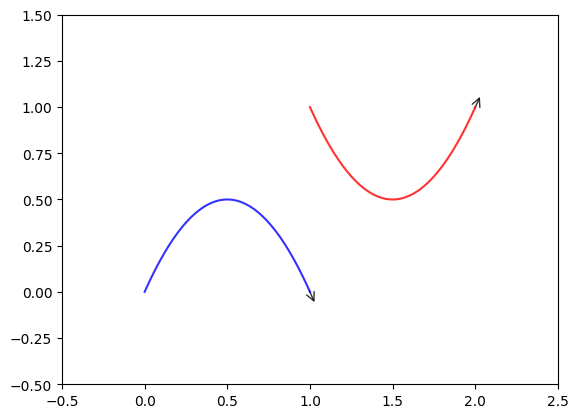

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_curve_with_arrow(ax, p0, p1, p2, z_layer, link_color, show_arrow=False, arrow_scale=0.1, arrow_color='black'):
    """
    Plots a quadratic Bezier curve with an optional arrowhead in 2D.

    Args:
        ax: Matplotlib axes object to draw on.
        p0: Tuple (x, y) representing the starting point.
        p1: Tuple (x, y) representing the control point.
        p2: Tuple (x, y) representing the ending point.
        z_layer: Z-coordinate (ignored in 2D plotting).
        link_color: Color of the curve.
        show_arrow: Boolean indicating whether to draw an arrowhead.
        arrow_scale: Controls the size of the arrowhead.
        arrow_color: Color of the arrowhead.
    """
    t_vals = np.linspace(0, 1, 100) 
    curve_x = (1 - t_vals) ** 2 * p0[0] + 2 * (1 - t_vals) * t_vals * p1[0] + t_vals ** 2 * p2[0]
    curve_y = (1 - t_vals) ** 2 * p0[1] + 2 * (1 - t_vals) * t_vals * p1[1] + t_vals ** 2 * p2[1]

    ax.plot(curve_x, curve_y, color=link_color, alpha=0.8)

    if show_arrow: 
        # Calculate tangent for arrow direction
        tangent_x = 2 * (1 - t_vals[-1]) * (p1[0] - p0[0]) + 2 * t_vals[-1] * (p2[0] - p1[0])
        tangent_y = 2 * (1 - t_vals[-1]) * (p1[1] - p0[1]) + 2 * t_vals[-1] * (p2[1] - p1[1])
        direction = np.array([tangent_x, tangent_y])

        if np.linalg.norm(direction) == 0:
            return 

        direction = direction / np.linalg.norm(direction) * arrow_scale
        arrow_start = np.array([curve_x[-2], curve_y[-2]])

        # Use FancyArrowPatch for the curved arrowhead (in 2D)
        arrow = patches.FancyArrowPatch(
            arrow_start,
            arrow_start + direction,
            connectionstyle="arc3,rad=0.01",  # Adjust curvature as needed
            arrowstyle='->', 
            mutation_scale=15,  # Adjust arrowhead size
            lw=1.0,  # Linewidth
            color=arrow_color,
            alpha=0.8
        )
        ax.add_patch(arrow)


# Example usage (2D plot)
fig, ax = plt.subplots()

plot_curve_with_arrow(ax, (0, 0), (0.5, 1), (1, 0), 0, 'blue', show_arrow=True)
plot_curve_with_arrow(ax, (1, 1), (1.5, 0), (2, 1), 0, 'red', show_arrow=True)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
plt.show()



